In [1]:
import sys
sys.path.append('../code/')

In [2]:
%load_ext autoreload
%autoreload 2

from libs import io
from libs import constants
from libs import vis
from postprocessing import consistency as cons

# Setup

In [3]:
VALID_RESPONSES_PATH = '../results/valid_responses'
PLOTS_PATH = '../results/plots'

FIGSIPER_CROWDED=(4.6,6)
FIGSPIDER = (5,7)
YLIM = (-0.01,1.02)

In [4]:
vis.sns_reset()
vis.sns_paper_style()

## Data

In [5]:
df_valid_responses = io.pd.concat([io.read_csv(io.path_join(VALID_RESPONSES_PATH, f"{model}.csv"), index_col=0) for model in constants.LLMS], ignore_index=True)
df_valid_responses['task_name'] = io.pd.Categorical(df_valid_responses['task_name'], categories=constants.EXPERIMENT_TASKS, ordered=True)
df_valid_responses.shape


(147622, 14)

In [6]:
df_valid_responses.head(2)

,date,time,llm_model,task_name,task_param,task_attempt,result_valid_flag,name,years,doi,career_age,clean_name,model,valid_attempt
0,2024-12-09,00:00,llama3-8b-8192,epoch,1950s,1,valid,Richard Feynman,1950-1960,NaN,NaN,richard feynman,llama3-8b,True
1,2024-12-09,00:00,llama3-8b-8192,epoch,1950s,1,valid,Julian Schwinger,1950-1960,NaN,NaN,julian schwinger,llama3-8b,True


# Consistency
Similarity of results

In [7]:
df_consistency = cons.run_consistency_jaccard_similarity(df_valid_responses)
df_consistency['task_name'] = io.pd.Categorical(df_consistency['task_name'], categories=constants.EXPERIMENT_TASKS, ordered=True)
df_consistency = df_consistency.groupby(['model','task_name']).average_jaccard_similarity.agg(['mean','std']).reset_index()

Processing Groups:  24%|██▍       | 21/87 [00:00<00:01, 63.24it/s]/home/espinl/.conda/envs/py311_llmscholar/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/espinl/.conda/envs/py311_llmscholar/lib/python3.11/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Processing Groups: 100%|██████████| 87/87 [00:01<00:00, 63.96it/s]
/tmp/ipykernel_1645769/2844552854.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_consistency = df_consistency.groupby(['model','task_name']).average_jaccard_similarity.agg(['mean','std']).reset_index()


In [8]:
df_consistency.head(2)

,model,task_name,mean,std
0,gemma2-9b,top_k,1.0,NaN
1,gemma2-9b,field,1.0,NaN


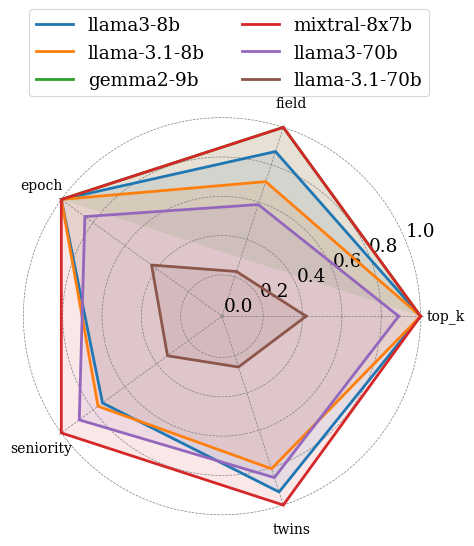

In [9]:
fn = io.path_join(PLOTS_PATH, 'consisetency_jaccard.pdf')

vis.plot_spiderweb(df_consistency, x_col='task_name', x_order=constants.EXPERIMENT_TASKS, y_col='mean',
                   hue='model', hue_order=constants.LLMS, hue_colors=constants.LLMS_COLORS,
                   ylim=YLIM,fn=fn,
                   legend_kwargs = {'title':'', 'loc': 'lower left', 'ncols':2, 'bbox_to_anchor':(0.0,1.02,1,0.2)},
                   figsize=FIGSPIDER)

# Uniqueness

In [10]:
df_duplicates = cons.run_consistency_uniqueness(df_valid_responses)
df_duplicates['task_name'] = io.pd.Categorical(df_duplicates['task_name'], categories=constants.EXPERIMENT_TASKS, ordered=True)
df_duplicates = df_duplicates.groupby(['model','task_name']).duplicates_pct.agg(['mean','std']).reset_index()
df_duplicates.head(2)

/tmp/ipykernel_1645769/1556376572.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_duplicates = df_duplicates.groupby(['model','task_name']).duplicates_pct.agg(['mean','std']).reset_index()


,model,task_name,mean,std
0,gemma2-9b,top_k,0.0,0.0
1,gemma2-9b,field,0.0,0.0


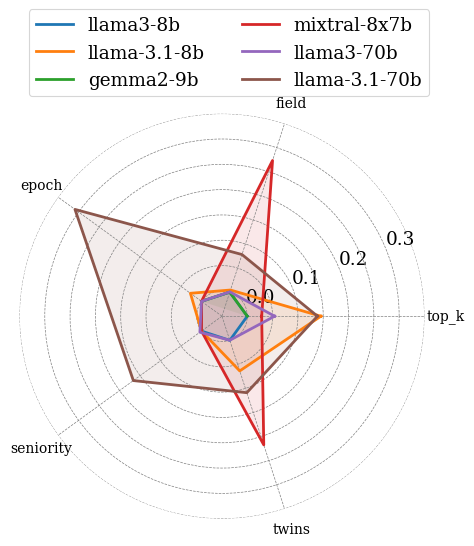

In [11]:
fn = io.path_join(PLOTS_PATH, 'consisetency_duplicates.pdf')

vis.plot_spiderweb(df_duplicates, x_col='task_name', x_order=constants.EXPERIMENT_TASKS, y_col='mean',
                   hue='model', hue_order=constants.LLMS, hue_colors=constants.LLMS_COLORS,
                   ylim=(-0.05,0.35), ytickval=0.5,fn=fn,
                   legend_kwargs = {'title':'', 'loc': 'lower left', 'ncols':2, 'bbox_to_anchor':(0.0,1.02,1,0.2)},
                   figsize=FIGSPIDER)